# 1. Background

## やること

Aiyagari ModelをDiscrete Dynamic Programming(以下、DDP)を用いて解く

Aiyagari Model: 以下のような分析に用いられる
- 収入リスクがあるときのprecautiary(予防的な)貯蓄や、借入制約の影響
- リスクシェアリング、アセットプライシング
- 富の分布の形状

## References

- Aiyagari Model
    - [Intermediate Quantitative Economics with Python: 74. The Aiyagari Model](https://python.quantecon.org/aiyagari.html)
    - [Aiyagari(1994)Uninsured Idiosyncratic Risk and Aggregate Saving](https://www.jstor.org/stable/2118417)
- DDP
    - [DiscreteDP: Getting Started with a Simple Example](https://notes.quantecon.org/submission/5bd7a72df966080015bafbd1)
    - [Advanced Quantitative Economics with Python: 4. Discrete State Dynamic Programming](https://python-advanced.quantecon.org/discrete_dp.html)

# 2.  Model

## 前提
- エージェントは異質的
- 借入・貸付に関して、外生的な手段1つのみ
- 借入制約あり

## Households' Problem

消費者は無限期間を生きるとし、個人個人に特有の(idiosyncratic)収入ショック( $ z_t $ )に直面すると仮定する。

家計は、以下の最大化問題を解く。

\begin{align}
\max \; & \mathbb E[ \sum_{t=0}^{\infty} \beta^t u(c_t)] \\
\text{s.t.} \\
a_{t+1} + c_t &\leq w z_t + (1 + r) a_t, \\
c_t &\geq 0,  \\
a_t &\geq -B,
\end{align}

where

- $ c_t $ : 今期の消費
- $ a_t $ : 資産
- $ z_t $ : 労働収入に関する外生的・確率的なリスク（e.g., 失業など）
- $ w $ : 賃金率
- $ r $ : 実質利子率
- $ B $ : エージェントが借りられる最大値

その他、以下を仮定。
- $ \{z_t\} $ は、stochastic matrix $ P $のもとで、a finite state Markov chainに従うとする。
- 賃金率・利子率は一定。

※家計は余暇を効用に考慮していないため、労働供給を非弾力的に供給する。

Recursive formulationは以下

\begin{align}
v(a, z) = \max_{a' \geq -B} \left\{ u(wz+(1+r)a-a') +\beta \cdot \mathbb E[v(a', z')] \right\},
\end{align}

where
- State variables: $ (z, a) $,
- Control variables: $ a' $

## Firms' Problem


企業は競争的に行動し、CRS生産関数を仮定。結果的に企業の数は関係なくなるため、代表的企業を考慮する。

企業のアウトプットは以下。

\begin{align}
Y_t = A K_t^{\alpha} N^{1 - \alpha},
\end{align}

where
- $ A > 0 $,   $ \alpha \in (0, 1) $  
- $ K_t $ : 総資本
- $ N $ : 総労働供給（※Household Problemでの仮定により、一定）

また、企業は以下の最大化問題を解く。

\begin{align}
max_{K, N} \left\{ A K_t^{\alpha} N^{1 - \alpha} - (r + \delta) K - w N \right\},
\end{align}
where
- $ \delta $ : 資本消耗率

KとNに関するFOCより、以下が得られる。

\begin{align}
    \begin{cases}
        r &= A \alpha  \left( \frac{N}{K} \right)^{1 - \alpha} - \delta,  \\
        w(r) &= A  (1 - \alpha)  (\frac{A \alpha }{ r + \delta})^{\frac{\alpha}{1 - \alpha} }.
    \end{cases}
\end{align}



## 均衡: SREE(Stationary Rational Expectations Equilibrium)

以下を満たすprices, savings and production policiesの集合を考える

- 価格を所与として、家計は上記の最大化問題を解く
- 価格を所与として、企業は上記の最大化問題を解く
- 資本に関して、総需要と総供給が一致
- 総量は一定

# 3. Computation

## Overview

-  [QuantEcon.py](https://quantecon.org/quantecon-py/).の[DiscreteDP](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/markov/ddp.py) class を用いる
- Households Problemのパラメータをもとに利得行列R、確率遷移行列Qを生成する必要がある
    - `R`(n × m): `R[s, a]`は、状態`s`において、アクション`a`により得られる利得を表す
    - `Q`(n × m × n): `Q[s, a, s']`は、今期の状態が`s`で今期のアクションが`a`のときに、次期に状態`s'`に遷移する確率を表す
- 状態: $ s_t := (a_t, z_t) $
    - $ a_t $: 資産
    - $ z_t $: ショック
- アクション: $ a_{t+1} $
    - 次期の資産
- 効用関数:
    - $ u(c) = log(c) $ と仮定する

## Import Libraries

In [3]:
!pip install quantecon

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from quantecon.markov import DiscreteDP
from numba import jit

## Setting

In [5]:
class Household:
    """
    This class takes the parameters that define a household asset accumulation
    problem and computes the corresponding reward and transition matrices R
    and Q required to generate an instance of DiscreteDP, and thereby solve
    for the optimal policy.

    Comments on indexing: We need to enumerate the state space S as a sequence
    S = {0, ..., n}.  To this end, (a_i, z_i) index pairs are mapped to s_i
    indices according to the rule

        s_i = a_i * z_size + z_i

    To invert this map, use

        a_i = s_i // z_size  (integer division)
        z_i = s_i % z_size

    """


    def __init__(self,
                r=0.01,                      # Interest rate
                w=1.0,                       # Wages
                β=0.96,                      # Discount factor
                a_min=1e-10,
                Π=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                z_vals=[0.1, 1.0],           # Exogenous states
                a_max=18,
                a_size=200):

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size

        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)

        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = a_size * self.z_size

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()

    def set_prices(self, r, w):
        """
        Use this method to reset prices. Calling the method will trigger a
        re-build of R.
        """
        self.r, self.w = r, w
        self.build_R()

    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
        self.R.fill(-np.inf)
        populate_R(self.R,
                self.a_size,
                self.z_size,
                self.a_vals,
                self.z_vals,
                self.r,
                self.w)


# Do the hard work using JIT-ed functions

@jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = a_vals[new_a_i]
            c = w * z + (1 + r) * a - a_new
            if c > 0:
                R[s_i, new_a_i] = np.log(c)  # Utility

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i*z_size + next_z_i] = Π[z_i, next_z_i]


@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i] += s_probs[a_i*z_size + z_i]
    return a_probs

## 価格を固定したときの、資産蓄積政策の推移を求める

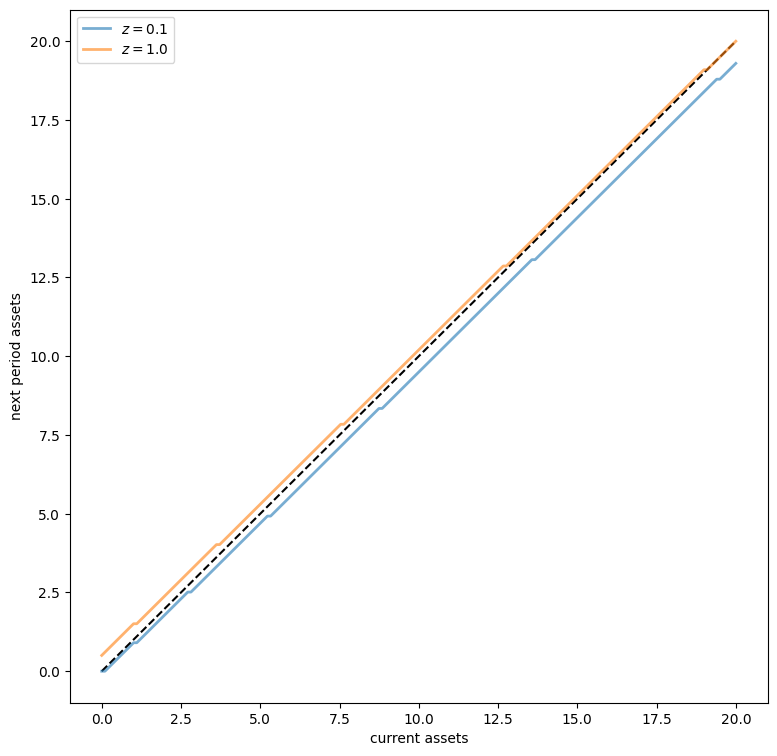

In [6]:
# Example prices
r = 0.03
w = 0.956

# Create an instance of Household
am = Household(a_max=20, r=r, w=w)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Solve using policy function iteration
results = am_ddp.solve(method='policy_iteration')

# Simplify names
z_size, a_size = am.z_size, am.a_size
z_vals, a_vals = am.z_vals, am.a_vals
n = a_size * z_size

# Get all optimal actions across the set of a indices with z fixed in each row
a_star = np.empty((z_size, a_size))
for s_i in range(n):
    a_i = s_i // z_size
    z_i = s_i % z_size
    a_star[z_i, a_i] = a_vals[results.sigma[s_i]]

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_vals, a_vals, 'k--')  # 45 degrees
for i in range(z_size):
    lb = f'$z = {z_vals[i]:.2}$'
    ax.plot(a_vals, a_star[i, :], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')

plt.show()

## 均衡を求める

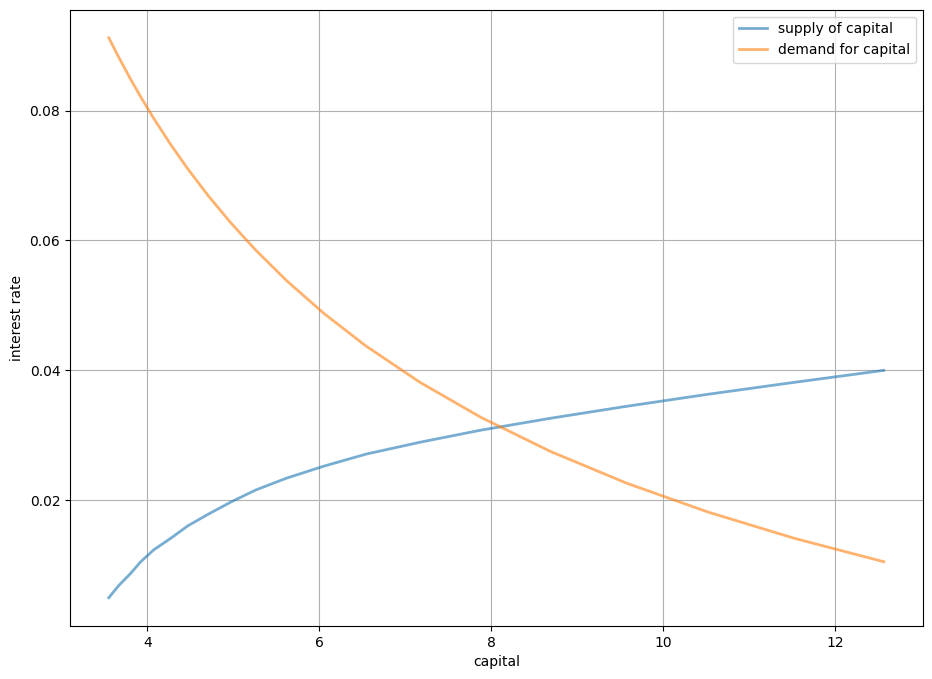

In [7]:
A = 1.0
N = 1.0
α = 0.33
β = 0.96
δ = 0.05


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * α * (N / K)**(1 - α) - δ


def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.

    Parameters:
    ----------

    am : Household
        An instance of an aiyagari_household.Household
    r : float
        The interest rate
    """
    w = r_to_w(r)
    am.set_prices(r, w)
    aiyagari_ddp = DiscreteDP(am.R, am.Q, β)
    # Compute the optimal policy
    results = aiyagari_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    # Return K
    return np.sum(asset_probs * am.a_vals)


# Create an instance of Household
am = Household(a_max=20)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Create a grid of r values at which to compute demand and supply of capital
num_points = 20
r_vals = np.linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am, r)

# Plot against demand for capital by firms
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')

plt.show()